In [1]:
!pip install torchtext==0.6.0
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2
2023-06-03 20:45:48.201555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 20:45:49.661661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-03 20:45:51.310993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from

In [2]:
import os

os.makedirs("saved", exist_ok=True)
os.makedirs("result", exist_ok=True)

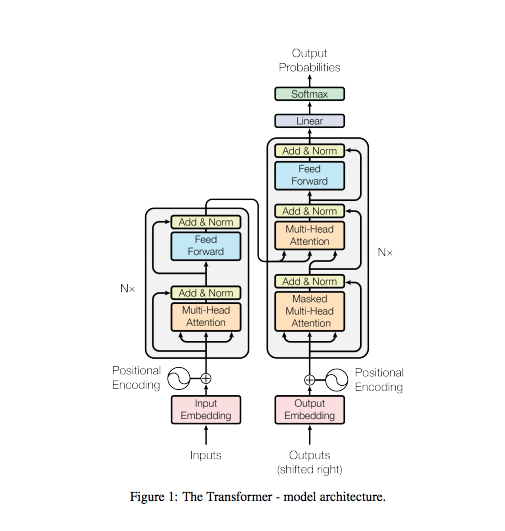

In [3]:
import torch
from torch import nn
import math
import spacy
import time
from torch import nn, optim
from torch.optim import Adam
from collections import Counter
import numpy as np

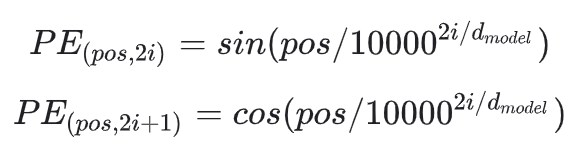

In [4]:
class PositionalEncoding(nn.Module):
    """
    compute sinusoid encoding.
    """
    def __init__(self, d_model, max_len, device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]         

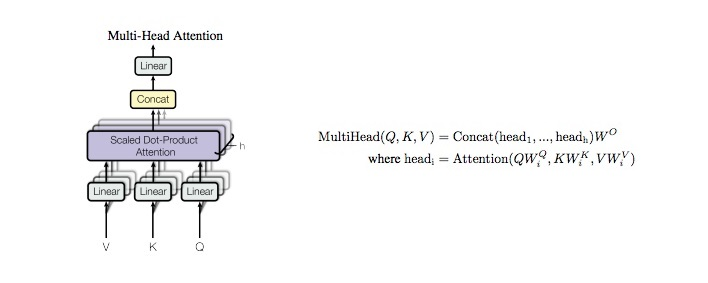

In [5]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, mask=mask)
        
        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)

        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

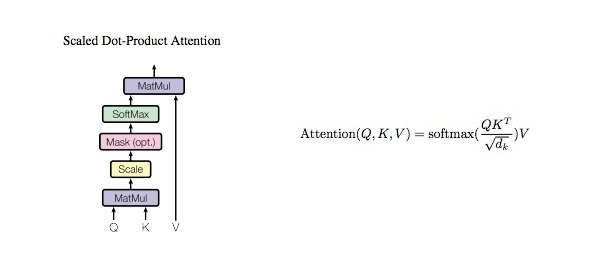

In [6]:
class ScaleDotProductAttention(nn.Module):
    """
    compute scale dot product attention

    Query : given sentence that we focused on (decoder)
    Key : every sentence to check relationship with Qeury(encoder)
    Value : every sentence same with Key (encoder)
    """

    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, e=1e-12):
        # input is 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        k_t = k.transpose(2, 3)  # transpose
        score = (q @ k_t) / math.sqrt(d_tensor)  # scaled dot product

        # 2. apply masking (opt)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)

        # 3. pass them softmax to make [0, 1] range
        score = self.softmax(score)

        # 4. multiply with Value
        v = score @ v

        return v, score

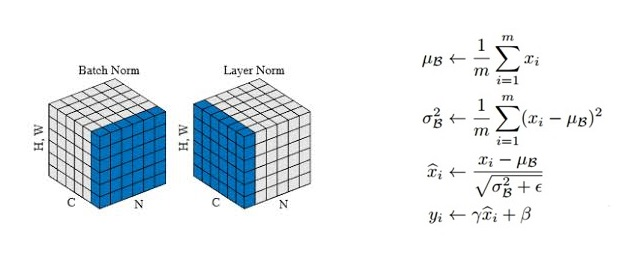

In [7]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        # '-1' means last dimension. 

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out


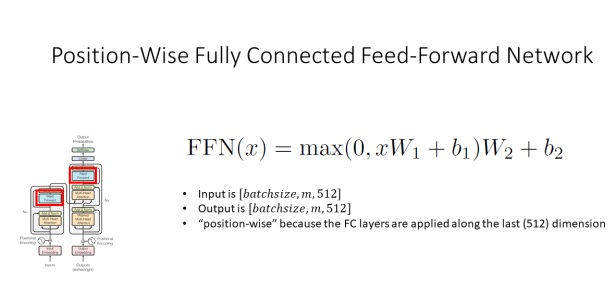

In [8]:
class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

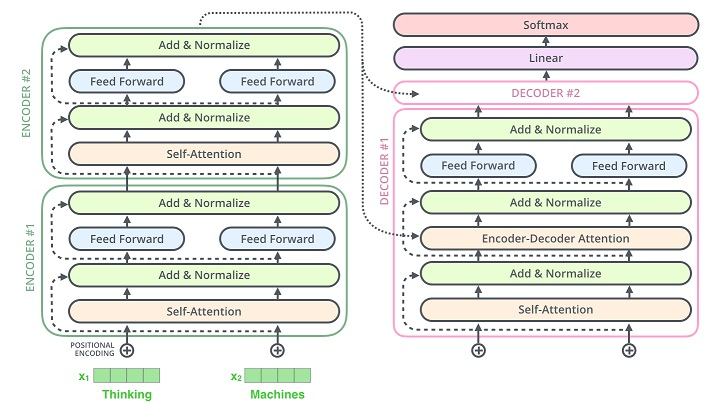

In [9]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, src_mask):
        # 1. compute self attention
        _x = x
        x = self.attention(q=x, k=x, v=x, mask=src_mask)
        
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)
        
        # 3. positionwise feed forward network
        _x = x
        x = self.ffn(x)
      
        # 4. add and norm
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        return x

In [10]:
class TokenEmbedding(nn.Embedding):
    """
    Token Embedding using torch.nn
    they will dense representation of word using weighted matrix
    """

    def __init__(self, vocab_size, d_model):
        """
        class for token embedding that included positional information
        :param vocab_size: size of vocabulary
        :param d_model: dimensions of model
        """
        super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx=1)

In [11]:
class TransformerEmbedding(nn.Module):
    """
    token embedding + positional encoding (sinusoid)
    positional encoding can give positional information to network
    """

    def __init__(self, vocab_size, d_model, max_len, drop_prob, device):
        """
        class for word embedding that included positional information
        :param vocab_size: size of vocabulary
        :param d_model: dimensions of model
        """
        super(TransformerEmbedding, self).__init__()
        self.tok_emb = TokenEmbedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_len, device)
        self.drop_out = nn.Dropout(p=drop_prob)

    def forward(self, x):
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)
        return self.drop_out(tok_emb + pos_emb)

In [12]:
class Encoder(nn.Module):

    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        max_len=max_len,
                                        vocab_size=enc_voc_size,
                                        drop_prob=drop_prob,
                                        device=device)

        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

    def forward(self, x, src_mask):
        x = self.emb(x)

        for layer in self.layers:
            x = layer(x, src_mask)

        return x

In [13]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.enc_dec_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = LayerNorm(d_model=d_model)
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, dec, enc, trg_mask, src_mask):    
        # 1. compute self attention
        _x = dec
        x = self.self_attention(q=dec, k=dec, v=dec, mask=trg_mask)
        
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        if enc is not None:
            # 3. compute encoder - decoder attention
            _x = x
            x = self.enc_dec_attention(q=x, k=enc, v=enc, mask=src_mask)
            
            # 4. add and norm
            x = self.dropout2(x)
            x = self.norm2(x + _x)

        # 5. positionwise feed forward network
        _x = x
        x = self.ffn(x)
        
        # 6. add and norm
        x = self.dropout3(x)
        x = self.norm3(x + _x)
        return x

In [14]:
class Decoder(nn.Module):
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        drop_prob=drop_prob,
                                        max_len=max_len,
                                        vocab_size=dec_voc_size,
                                        device=device)

        self.layers = nn.ModuleList([DecoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

        self.linear = nn.Linear(d_model, dec_voc_size)

    def forward(self, trg, src, trg_mask, src_mask):
        trg = self.emb(trg)

        for layer in self.layers:
            trg = layer(trg, src, trg_mask, src_mask)

        # pass to LM head
        output = self.linear(trg)
        return output

In [15]:
class Transformer(nn.Module):

    def __init__(self, src_pad_idx, trg_pad_idx, trg_sos_idx, enc_voc_size, dec_voc_size, d_model, n_head, max_len,
                 ffn_hidden, n_layers, drop_prob, device):
        super().__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        self.encoder = Encoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               enc_voc_size=enc_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

        self.decoder = Decoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               dec_voc_size=dec_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

    def forward(self, src, trg):
        src_mask = self.make_pad_mask(src, src, self.src_pad_idx, self.src_pad_idx)

        src_trg_mask = self.make_pad_mask(trg, src, self.trg_pad_idx, self.src_pad_idx)

        trg_mask = self.make_pad_mask(trg, trg, self.trg_pad_idx, self.trg_pad_idx) * \
                   self.make_no_peak_mask(trg, trg)

        enc_src = self.encoder(src, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_trg_mask)
        return output

    def make_pad_mask(self, q, k, q_pad_idx, k_pad_idx):
        len_q, len_k = q.size(1), k.size(1)

        # batch_size x 1 x 1 x len_k
        k = k.ne(k_pad_idx).unsqueeze(1).unsqueeze(2)
        # batch_size x 1 x len_q x len_k
        k = k.repeat(1, 1, len_q, 1)

        # batch_size x 1 x len_q x 1
        q = q.ne(q_pad_idx).unsqueeze(1).unsqueeze(3)
        # batch_size x 1 x len_q x len_k
        q = q.repeat(1, 1, 1, len_k)

        mask = k & q
        return mask

    def make_no_peak_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # len_q x len_k
        mask = torch.tril(torch.ones(len_q, len_k)).type(torch.BoolTensor).to(self.device)

        return mask

In [16]:
from torchtext.data import Field, BucketIterator
from torchtext.datasets.translation import Multi30k

class DataLoader:
    source: Field = None
    target: Field = None

    def __init__(self, ext, tokenize_en, tokenize_de, init_token, eos_token):
        self.ext = ext
        self.tokenize_en = tokenize_en
        self.tokenize_de = tokenize_de
        self.init_token = init_token
        self.eos_token = eos_token
        print('dataset initializing start')

    def make_dataset(self):
        if self.ext == ('.de', '.en'):
            self.source = Field(tokenize=self.tokenize_de, init_token=self.init_token, eos_token=self.eos_token,
                                lower=True, batch_first=True)
            self.target = Field(tokenize=self.tokenize_en, init_token=self.init_token, eos_token=self.eos_token,
                                lower=True, batch_first=True)

        elif self.ext == ('.en', '.de'):
            self.source = Field(tokenize=self.tokenize_en, init_token=self.init_token, eos_token=self.eos_token,
                                lower=True, batch_first=True)
            self.target = Field(tokenize=self.tokenize_de, init_token=self.init_token, eos_token=self.eos_token,
                                lower=True, batch_first=True)

        train_data, valid_data, test_data = Multi30k.splits(exts=self.ext, fields=(self.source, self.target))
        return train_data, valid_data, test_data

    def build_vocab(self, train_data, min_freq):
        self.source.build_vocab(train_data, min_freq=min_freq)
        self.target.build_vocab(train_data, min_freq=min_freq)

    def make_iter(self, train, validate, test, batch_size, device):
        train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train, validate, test),
                                                                              batch_size=batch_size,
                                                                              device=device)
        print('dataset initializing done')
        return train_iterator, valid_iterator, test_iterator

In [17]:
class Tokenizer:

    def __init__(self):
        self.spacy_de = spacy.load('de_core_news_sm')
        self.spacy_en = spacy.load('en_core_web_sm')

    def tokenize_de(self, text):
        """
        Tokenizes German text from a string into a list of strings
        """
        return [tok.text for tok in self.spacy_de.tokenizer(text)]

    def tokenize_en(self, text):
        """
        Tokenizes English text from a string into a list of strings
        """
        return [tok.text for tok in self.spacy_en.tokenizer(text)]

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)

In [20]:
# GPU device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model parameter setting
batch_size = 128
max_len = 256
d_model = 512
n_layers = 6
n_heads = 8
ffn_hidden = 2048
drop_prob = 0.1

# optimizer parameter setting
init_lr = 1e-5
factor = 0.9
adam_eps = 5e-9
patience = 10
warmup = 100
epoch = 2#1000
clip = 1.0
weight_decay = 5e-4
inf = float('inf')

In [21]:
tokenizer = Tokenizer()
loader = DataLoader(ext=('.en', '.de'),
                    tokenize_en=tokenizer.tokenize_en,
                    tokenize_de=tokenizer.tokenize_de,
                    init_token='<sos>',
                    eos_token='<eos>')

train, valid, test = loader.make_dataset()
loader.build_vocab(train_data=train, min_freq=2)
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=batch_size,
                                                     device=device)

src_pad_idx = loader.source.vocab.stoi['<pad>']
trg_pad_idx = loader.target.vocab.stoi['<pad>']
trg_sos_idx = loader.target.vocab.stoi['<sos>']

enc_voc_size = len(loader.source.vocab)
dec_voc_size = len(loader.target.vocab)

dataset initializing start
downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 6.83MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.43MB/s]

downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.60MB/s]


dataset initializing done


In [22]:
model = Transformer(src_pad_idx=src_pad_idx,
                    trg_pad_idx=trg_pad_idx,
                    trg_sos_idx=trg_sos_idx,
                    d_model=d_model,
                    enc_voc_size=enc_voc_size,
                    dec_voc_size=dec_voc_size,
                    max_len=max_len,
                    ffn_hidden=ffn_hidden,
                    n_head=n_heads,
                    n_layers=n_layers,
                    drop_prob=drop_prob,
                    device=device).to(device)


In [23]:
print(f'The model has {count_parameters(model):,} trainable parameters')
model.apply(initialize_weights)
optimizer = Adam(params=model.parameters(),
                 lr=init_lr,
                 weight_decay=weight_decay,
                 eps=adam_eps)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 verbose=True,
                                                 factor=factor,
                                                 patience=patience)

criterion = nn.CrossEntropyLoss(ignore_index=src_pad_idx)

The model has 55,205,037 trainable parameters


<ipython-input-19-ecdb7627acda>:3: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


In [24]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        output = model(src, trg[:, :-1])
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output_reshape, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        print('step :', round((i / len(iterator)) * 100, 2), '% , loss :', loss.item())

    return epoch_loss / len(iterator)


In [25]:
def bleu_stats(hypothesis, reference):
    """Compute statistics for BLEU."""
    stats = []
    stats.append(len(hypothesis))
    stats.append(len(reference))
    for n in range(1, 5):
        s_ngrams = Counter(
            [tuple(hypothesis[i:i + n]) for i in range(len(hypothesis) + 1 - n)]
        )
        r_ngrams = Counter(
            [tuple(reference[i:i + n]) for i in range(len(reference) + 1 - n)]
        )

        stats.append(max([sum((s_ngrams & r_ngrams).values()), 0]))
        stats.append(max([len(hypothesis) + 1 - n, 0]))
    return stats


def bleu(stats):
    """Compute BLEU given n-gram statistics."""
    if len(list(filter(lambda x: x == 0, stats))) > 0:
        return 0
    (c, r) = stats[:2]
    log_bleu_prec = sum(
        [math.log(float(x) / y) for x, y in zip(stats[2::2], stats[3::2])]
    ) / 4.
    return math.exp(min([0, 1 - float(r) / c]) + log_bleu_prec)


def get_bleu(hypotheses, reference):
    """Get validation BLEU score for dev set."""
    stats = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for hyp, ref in zip(hypotheses, reference):
        stats += np.array(bleu_stats(hyp, ref))
    return 100 * bleu(stats)


def idx_to_word(x, vocab):
    words = []
    for i in x:
        word = vocab.itos[i]
        if '<' not in word:
            words.append(word)
    words = " ".join(words)
    return words

In [26]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    batch_bleu = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            output = model(src, trg[:, :-1])
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output_reshape, trg)
            epoch_loss += loss.item()

            total_bleu = []
            for j in range(batch_size):
                try:
                    trg_words = idx_to_word(batch.trg[j], loader.target.vocab)
                    output_words = output[j].max(dim=1)[1]
                    output_words = idx_to_word(output_words, loader.target.vocab)
                    bleu = get_bleu(hypotheses=output_words.split(), reference=trg_words.split())
                    total_bleu.append(bleu)
                except:
                    pass

            total_bleu = sum(total_bleu) / len(total_bleu)
            batch_bleu.append(total_bleu)

    batch_bleu = sum(batch_bleu) / len(batch_bleu)
    return epoch_loss / len(iterator), batch_bleu



In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
def run(total_epoch, best_loss):
    train_losses, test_losses, bleus = [], [], []
    for step in range(total_epoch):
        start_time = time.time()
        train_loss = train(model, train_iter, optimizer, criterion, clip)
        valid_loss, bleu = evaluate(model, valid_iter, criterion)
        end_time = time.time()

        if step > warmup:
            scheduler.step(valid_loss)

        train_losses.append(train_loss)
        test_losses.append(valid_loss)
        bleus.append(bleu)
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), 'saved/model-{0}.pt'.format(valid_loss))

        f = open('result/train_loss.txt', 'w')
        f.write(str(train_losses))
        f.close()

        f = open('result/bleu.txt', 'w')
        f.write(str(bleus))
        f.close()

        f = open('result/test_loss.txt', 'w')
        f.write(str(test_losses))
        f.close()

        print(f'Epoch: {step + 1} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tVal Loss: {valid_loss:.3f} |  Val PPL: {math.exp(valid_loss):7.3f}')
        print(f'\tBLEU Score: {bleu:.3f}')


In [29]:
run(total_epoch=epoch, best_loss=inf)

step : 0.0 % , loss : 9.99052906036377
step : 0.44 % , loss : 9.750131607055664
step : 0.88 % , loss : 9.412054061889648
step : 1.32 % , loss : 9.205595016479492
step : 1.76 % , loss : 8.940683364868164
step : 2.2 % , loss : 8.747406959533691
step : 2.64 % , loss : 8.583481788635254
step : 3.08 % , loss : 8.472567558288574
step : 3.52 % , loss : 8.452555656433105
step : 3.96 % , loss : 8.305564880371094
step : 4.41 % , loss : 8.157515525817871
step : 4.85 % , loss : 8.121931076049805
step : 5.29 % , loss : 8.128534317016602
step : 5.73 % , loss : 7.993347644805908
step : 6.17 % , loss : 8.08080005645752
step : 6.61 % , loss : 7.952334880828857
step : 7.05 % , loss : 7.8590826988220215
step : 7.49 % , loss : 7.818441390991211
step : 7.93 % , loss : 7.696659564971924
step : 8.37 % , loss : 7.613630771636963
step : 8.81 % , loss : 7.811493396759033
step : 9.25 % , loss : 7.663742542266846
step : 9.69 % , loss : 7.605291366577148
step : 10.13 % , loss : 7.569988250732422
step : 10.57 % , l

In [34]:
from os import walk

saved_model = next(walk("/content/saved"), (None, None, []))[2]  # [] if no fi
saved_model

['model-5.97998720407486.pt']

In [35]:
def test_model(num_examples):
    iterator = test_iter
    model.load_state_dict(torch.load(f"saved/{saved_model[-1]}"))

    with torch.no_grad():
        batch_bleu = []
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            output = model(src, trg[:, :-1])

            total_bleu = []
            for j in range(num_examples):
                try:
                    src_words = idx_to_word(src[j], loader.source.vocab)
                    trg_words = idx_to_word(trg[j], loader.target.vocab)
                    output_words = output[j].max(dim=1)[1]
                    output_words = idx_to_word(output_words, loader.target.vocab)

                    print('source :', src_words)
                    print('target :', trg_words)
                    print('predicted :', output_words)
                    print()
                    bleu = get_bleu(hypotheses=output_words.split(), reference=trg_words.split())
                    total_bleu.append(bleu)
                except:
                    pass

            total_bleu = sum(total_bleu) / len(total_bleu)
            print('BLEU SCORE = {}'.format(total_bleu))
            batch_bleu.append(total_bleu)

        batch_bleu = sum(batch_bleu) / len(batch_bleu)
        print('TOTAL BLEU SCORE = {}'.format(batch_bleu))


In [36]:
test_model(num_examples=batch_size)

source : two workers spread cement onto a brick building .
target : zwei arbeiter streichen zement auf einen ziegelbau .
predicted : . . . . . . . . . .

source : people in at forest next to canoes .
target : leute entspannen in einem wald neben kanus .
predicted : . . . . . . . . . .

source : a black dog up into a pool .
target : ein schwarzer hund springt in einen pool .
predicted : . . . . . . . . . .

source : a man using a chainsaw to cut .
target : ein mann schneidet holz mit einer kettensäge .
predicted : . . . . . . . . . .

source : a woman is holding a small white statue .
target : eine frau hält eine kleine weiße statue .
predicted : . . . . . . . . . .

source : two brown dogs are running through the snow .
target : zwei braune hunde rennen durch den schnee .
predicted : . . . . . . . . . .

source : two young boys putting fruit on the bike .
target : zwei jungen packen obst auf das fahrrad .
predicted : . . . . . . . . . .

source : a cheerleading team doing a routine on 